<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_RegressionLineaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place une regression linéaire à l'aide d'un réseau de neurones sur notre série temporelle. Pour cela, nous allons suivre les étapes suivantes :
  - Reprendre le code nécessaire pour créer notre série temporelle
  - Définir une fonction permettant de préparer les données d'entrée X et les labels Y pour attaquer notre réseau de régression linéaire
  - Préparer les données X et Y avec la fonction définie précédemment.
  - Construire un réseau de neurones pour réaliser une régression linéaire
  - Entrainer le modèle avec les données X et Y
  - Réaliser des prédictions sur la série temporelle avec notre modèle
  - Mesurer les erreurs

In [43]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

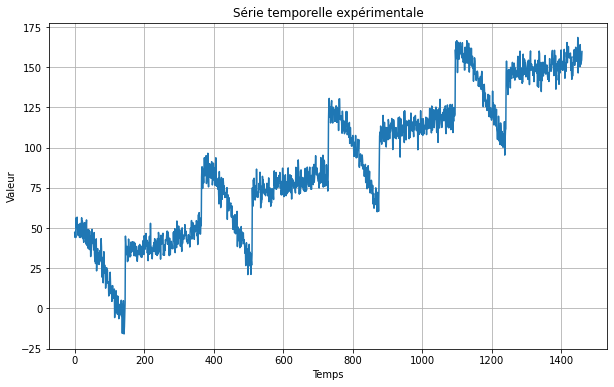

In [59]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

Regardons le format de la série temporelle que nous avons pour le moment :

In [45]:
print(serie.shape)
print(serie[0:5])

(1460,)
[51.28338563 44.08280687 51.50709973 53.3739123  64.2633703 ]


# Préparation des données X et Y

Définissons la fonction `prepare_dataset_XY` qui va permettre de créer les données X Y pour le réseau de neurones. Cette fonction retourne une classe Dataset et prend comme  paramètres :
 - `serie` : La série temporelle à traiter
 - `taille_fenetre` : La taille de la fenêtre glissante
 - `batch_size` : La nombre de regroupements que l'on souhaite obtenir dans nos données X et Y : par exemple si X=(X1,X2) et Y=(Y1,Y2) alors il faut donner `batch_size = 2`
 - `buffer_melange` : Buffer pour le mélange des données  
   

Cette fonction utilise la méthode [from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) de la classe Dataset de Tensorflow afin d'extraire une coupe depuis la série originale et de créer un dataset dont les éléments sont les valeurs de la série :

In [46]:
# Création d'un dataset à partir de la série temporelle
dataset = tf.data.Dataset.from_tensor_slices(serie)

# Affichage  des 5 premiers éléments du dataset
for vecteur in dataset.take(5):
  print(vecteur.numpy())

51.28338563148519
44.082806870157356
51.5070997285837
53.373912303059555
64.26337029655322


In [47]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Regardons un exemple :

In [ ]:
test = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
dataset = prepare_dataset_XY(serie=test,taille_fenetre=3,batch_size=3,buffer_melange=20)
list(dataset.as_numpy_iterator())

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [48]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [49]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)

Regardons ce qu'on obtient :

In [50]:
# Affiche le nombre total d'éléments dans le dataset
print("Nombre total d'éléments dans le dataset : %d" %len(list(dataset.as_numpy_iterator())))

# Affiche le premier élément du dataset
print("Premier élément dans le dataset :")
for element in dataset.take(1):
  print(element)

Nombre total d'éléments dans le dataset : 45
Premier élément dans le dataset :
(<tf.Tensor: shape=(32, 20), dtype=float64, numpy=
array([[ 26.74379696,  26.58103065,  16.48586789,  29.91583843,
         22.57299623,  20.49274563,  25.96837545,  23.05091441,
         26.68889781,  18.06728461,  20.86858738,  26.37269116,
         20.51744904,  22.46702851,  22.06942905,  11.77981455,
         15.66069631,  22.31114759,  18.73857751,   9.22742965],
       [ 32.79669828,  34.02498224,  29.79855256,  38.87484189,
         36.29792056,  25.30623499,  35.13807433,  42.57188918,
         27.14956855,  40.78595535,  33.34092223,  35.17432418,
         35.44727472,  40.32627278,  41.00915573,  40.78316941,
         42.18436514,  37.02399233,  32.64539143,  44.88625375],
       [ 44.58515543,  36.23085654,  39.39249777,  44.22272385,
         38.2854085 ,  50.61183308,  29.64227245,  47.08346764,
         44.58916916,  38.07144919,  40.24416492,  47.29773918,
         32.94691031,  38.24358964, 

On obtient donc un dataset qui contient :
- 45 éléments de format (32,20) : Ce sont les groupes qui composent les entrées X
- 45 éléments de format (32,) : Ce sont les groupes qui composent les labels Y

Affichons la première entrée et le premier label correspondant à cette entrée :

In [ ]:
# Affiche la première entrée X :
for X,Y in dataset.take(1):
  print(X)

In [ ]:
# Affiche le premier label Y :
for X,Y in dataset.take(1):
  print(Y)

# Création et entrainement du modèle

**1. Création du réseau**

On met maintenant en place un réseau de neurone pour la régression linéaire constitué :
-  **D'une couche d'entrée avec 1 neurone** qui prend en entrée des **vecteurs 1D de dimension égale à la taille de la fenêtre** avec un **batch_size** de 32.  
On a donc 21 paramètres à calculer (20 poids + 1 offset).  
- On utilise un **taux d'apprentissage de 1e-6**
- On choisit un **optimiseur de type Descente de gradient stochastique et à moment** (MSGD - Momentum Stochastic Gradient Descent) avec un moment fixé à 0.9.  
- On utilise une **fonction d'objectif** de type **erreur moyenne quadratique** (mse - mean squared error)

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/1_neurone_2.png?raw=true" width="800"> 

In [51]:
# Création du modèle de régression linéaire

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(1))

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (32, 1)                   21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


Une autre possibilité pour construire ce réseau est d'empiler les couches les unes sur les autres comme ci-dessous. Cette solution a l'avantage de pouvoir par la suite accéder directement aux données de la couche qui nous interesse à l'aide du nom de sa variable :

In [8]:
# Construction du réseau avec nomination explicite du nom des couches

couche_0 = tf.keras.layers.Dense(1, input_shape=[taille_fenetre],batch_size=batch_size)
model = tf.keras.models.Sequential([couche_0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 1)                   21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [15]:
print(couche_0.input_shape)
print(couche_0.output_shape)

(32, 20)
(32, 1)


**2. Entrainement du réseau**

On entraine le réseau sur 100 périodes. Comme le modèle prend 1 élément (vecteur d'entrée X de dimension 20) à chaque itération, et qu'il y a 45 éléments, il y aura 45 itération par période.  
Pour entrainer notre réseau, on lui rentre un Dataset au format tensorflow. La méthode [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) de la classe Model de Keras permet de gérer ce genre d'entrée. Dans ce cas, le Dataset doit être au format `(entrées, labels)`, ce qui est notre cas.

In [9]:
# Lance l'entrainement du modèle

model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
45/45 [==============================] - 1s 4ms/step - loss: 4037.9443
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 178.5563
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 163.7485
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 135.2263
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 127.3945
Epoch 6/100
45/45 [==============================] - 0s 2ms/step - loss: 107.3107
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 110.7842
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 99.4740
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 105.3009
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 86.8735
Epoch 11/100
45/45 [==============================] - 0s 3ms/step - loss: 93.8283
Epoch 12/100
45/45 [==============================] - 0s 3ms/step - loss: 95.3018
Epoch 13/100
45/

**3. Extraction des paramètres de la couche du réseau**

On peut accéder aux paramètres de la couche du réseau avec le code suivant :

In [ ]:
print("Paramètres de la couche 0: {}".format(couche_0.get_weights()))

Les 20 poids sont contenus dans le premier vecteur, et l'offset est contenu dans le deuxième vecteur :

In [10]:
print("Poids de la couche 0: {}".format(couche_0.get_weights()[0]))
print("Offset de la couche 0: {}".format(couche_0.get_weights()[1]))

Poids de la couche 0: [[ 0.00500333]
 [-0.00949918]
 [-0.02939358]
 [ 0.04220093]
 [-0.03487412]
 [ 0.0303711 ]
 [-0.01343702]
 [ 0.01462929]
 [-0.0150249 ]
 [-0.00389288]
 [ 0.0245423 ]
 [ 0.01035436]
 [ 0.00506736]
 [ 0.01504732]
 [ 0.02346024]
 [ 0.00094595]
 [ 0.05012989]
 [ 0.15456748]
 [ 0.27430433]
 [ 0.44069892]]
Offset de la couche 0: [0.01360331]


# Prédictions avec le modèle

**1. Exemple de prédiction à partir d'une seule entrée de 20 valeurs extraites de la série**

Prenons par exemple les 20 première données de la série temporelle :

In [52]:
print(serie[0:20])

[51.28338563 44.08280687 51.50709973 53.3739123  64.2633703  54.37319463
 43.55391764 59.35440032 53.30700067 50.02609954 44.01066027 59.49558548
 48.6676138  44.66482772 48.09693925 46.12014939 47.27781352 49.91370303
 49.82051775 48.51920963]


Le format n'est pas compatible avec le réseau car le réseau demande un format d'entrée de (None,20) :

In [53]:
np.array(serie[0:20]).shape

(20,)

Il faut donc transformer ce format au bon format avant d'envoyer les données dans le réseau :

In [54]:
np.reshape(serie[0:20],(1,20)).shape

(1, 20)

On peut avec ce format appeler la méthode `predict` de la classe Model :

In [55]:
# Affiche les données d'entrée X
print(np.reshape(serie[0:20],(1,20)))

# Lance la prédiction
model.predict(np.reshape(serie[0:20],(1,20)))

[[51.28338563 44.08280687 51.50709973 53.3739123  64.2633703  54.37319463
  43.55391764 59.35440032 53.30700067 50.02609954 44.01066027 59.49558548
  48.6676138  44.66482772 48.09693925 46.12014939 47.27781352 49.91370303
  49.82051775 48.51920963]]


array([[27.686405]], dtype=float32)

**2. Prédictions de la série sur l'intervalle de validation**

In [ ]:
temps[temps_separation:]

In [72]:
# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:]:
  if len(serie[t:t+taille_fenetre]) == 20:
    X = np.reshape(serie[t:t+taille_fenetre],(1,20))
    predictions.append(model.predict(X))
  else:
    break

# Extrait uniquement les résultats de validation
predictions = predictions[temps_separation - taille_fenetre:]

[109.80107551 107.59866361 118.00322784 116.93074656 108.4660663
 113.5740433  112.37972132 113.90493186 111.6394591  113.55006507
 118.95481305 114.02244535 108.12620923 114.14440761 117.85860624
 118.37653866 111.70901467 114.07538773 115.78410527 117.12365468]
()


In [37]:
np.shape(predictions)

(460, 1, 1)

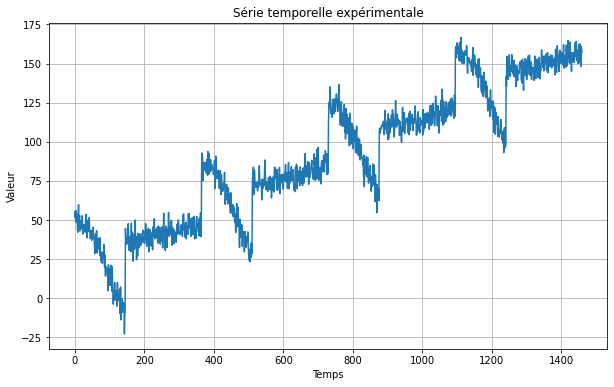

In [42]:
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()